In [29]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import roc_auc_score ,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [30]:
TRAIN_PATH = 'assignment_2_train.csv'
TEST_PATH = 'assignment_2_test.csv'
TARGET_COLUMN = 'isFraud'

In [31]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [32]:
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,W,1877,310.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179996,3166996,0,3958237,59.95,W,10075,514.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179997,3166997,0,3958241,34.00,W,6053,122.0,150.0,mastercard,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179998,3166998,0,3958260,59.00,W,7726,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Задание 1: 
сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (
TransactionID
), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [33]:
categorial_features = train.select_dtypes('object').columns.tolist()
drop_features = [TARGET_COLUMN, 'TransactionID', 'TransactionDT']

In [34]:
train[categorial_features] = train[categorial_features].astype(str)
test[categorial_features] = test[categorial_features].astype(str)

In [35]:
x_train, x_valid = train_test_split(train.drop(drop_features, axis=1), train_size=0.7, shuffle=True, random_state=47)
y_train, y_valid = train_test_split(train[TARGET_COLUMN], train_size=0.7, shuffle=True, random_state=47)
x_public = test.drop(drop_features, axis=1)
y_public = test[TARGET_COLUMN]

print("x_train = {} rows, {} cols".format(*x_train.shape))
print("x_valid = {} rows, {} cols".format(*x_valid.shape))
print("x_public = {} rows, {} cols".format(*x_public.shape))

x_train = 125999 rows, 391 cols
x_valid = 54001 rows, 391 cols
x_public = 100001 rows, 391 cols


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:22<00:00, 26.20s/it]


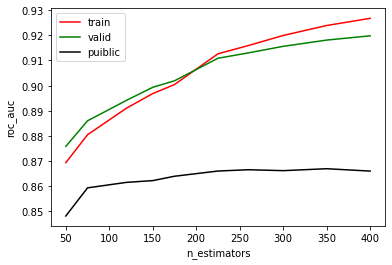

Wall time: 4min 22s


In [39]:
%%time
train_score = []
valid_score = []
public_score = []
n_estimators = [50, 75, 120, 150, 175, 225, 260, 300, 350, 400]
eval_set = [(x_valid, y_valid)]

for estimator in tqdm(n_estimators):
    cb_model = cb.CatBoostClassifier(cat_features=categorial_features, eval_metric='AUC', n_estimators=estimator,
                                     max_depth=5, early_stopping_rounds=10, learning_rate=0.1,
                                     silent=True, random_state=47
                                    )
    cb_model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, cb_model.predict_proba(x_train)[::, 1]))
    valid_score.append(roc_auc_score(y_valid, cb_model.predict_proba(x_valid)[::, 1]))
    public_score.append(roc_auc_score(y_public, cb_model.predict_proba(x_public)[::, 1]))

plt.plot(n_estimators, train_score, label='train', color='red')
plt.plot(n_estimators, valid_score, label='valid', color='green')
plt.plot(n_estimators, public_score, label='puiblic', color='black')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

Разница между метрикой ROC-AUC большая на тренировочной, валидационной и лб выборкой

# Задание 2:
сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [41]:
x_train, x_valid = train_test_split(train.drop(drop_features, axis=1), train_size=0.6, shuffle=True, random_state=47)
y_train, y_valid = train_test_split(train[TARGET_COLUMN], train_size=0.6, shuffle=True, random_state=47)
x_valid, x_test = train_test_split(x_valid, train_size=0.5, shuffle=True, random_state=47)
y_valid, y_test = train_test_split(y_valid, train_size=0.5, shuffle=True, random_state=47)
x_public = test.drop(drop_features, axis=1)
y_public = test[TARGET_COLUMN]
print("x_train = {} rows, {} cols".format(*x_train.shape))
print("x_valid = {} rows, {} cols".format(*x_valid.shape))
print("x_test = {} rows, {} cols".format(*x_test.shape))
print("x_public = {} rows, {} cols".format(*x_public.shape))

x_train = 108000 rows, 391 cols
x_valid = 36000 rows, 391 cols
x_test = 36000 rows, 391 cols
x_public = 100001 rows, 391 cols


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:41<00:00, 28.16s/it]


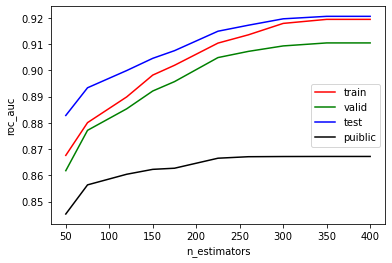

Wall time: 4min 41s


In [42]:
%%time
train_score = []
valid_score = []
test_score = []
public_score = []
n_estimators = [50, 75, 120, 150, 175, 225, 260, 300, 350, 400]
eval_set = [(x_valid, y_valid)]

for estimator in tqdm(n_estimators):
    cb_model = cb.CatBoostClassifier(cat_features=categorial_features, eval_metric='AUC', n_estimators=estimator,
                                     max_depth=5, early_stopping_rounds=10, learning_rate=0.1,
                                     silent=True, random_state=47
                                    )
    cb_model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, cb_model.predict_proba(x_train)[::, 1]))
    valid_score.append(roc_auc_score(y_valid, cb_model.predict_proba(x_valid)[::, 1]))
    test_score.append(roc_auc_score(y_test, cb_model.predict_proba(x_test)[::, 1]))
    public_score.append(roc_auc_score(y_public, cb_model.predict_proba(x_public)[::, 1]))

plt.plot(n_estimators, train_score, label='train', color='red')
plt.plot(n_estimators, valid_score, label='valid', color='green')
plt.plot(n_estimators, test_score, label='test', color='blue')
plt.plot(n_estimators, public_score, label='puiblic', color='black')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

Графики стали ближе друг к другу, но особое изменение в значении самой метрики ROC-AUC не поменялось

# Задание 3:
построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [43]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [69]:
cb_model = cb.CatBoostClassifier(cat_features=categorial_features, eval_metric='AUC', n_estimators=225,
                                     max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                     silent=True, random_state=47
                                    )
cb_model.fit(x_train, y_train, eval_set=eval_set)

In [70]:
print(roc_auc_score(y_public, cb_model.predict_proba(x_public)[:, 1]))

0.8661190339374006


In [71]:
np.random.seed(1)
scores = create_bootstrap_metrics(y_test, cb_model.predict_proba(x_test)[:, 1], roc_auc_score)
calculate_confidence_interval(scores)

(0.8889289747657235, 0.9103067800284027)

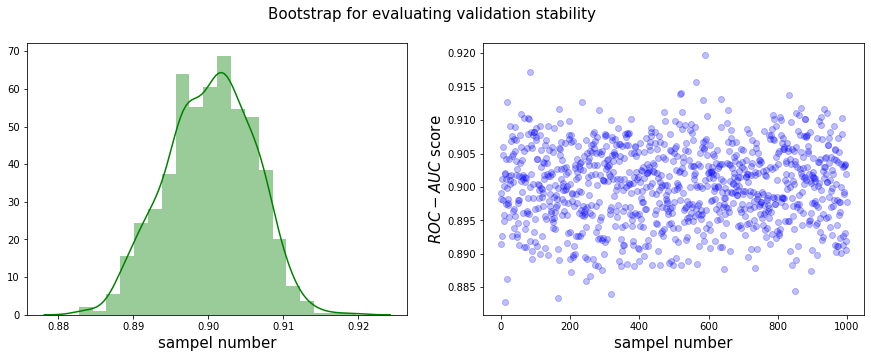

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$ROC-AUC$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)
plt.show()

Небольшой доверительный интервал, тестовая выборка не попадает в него.

# Задание 4:
выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из
assignment_2_test.csv
, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [59]:
x_adv = pd.concat([train, test])
y_adv = np.hstack((np.ones(train.shape[0]), np.zeros(test.shape[0])))
x_adv = x_adv.reset_index(drop=True)
x_adv = x_adv.drop(drop_features, axis=1)

In [60]:
cb_model = cb.CatBoostClassifier(cat_features=categorial_features, eval_metric='AUC', n_estimators=200,
                                     max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                     silent=True, random_state=47
                                    )
cb_model.fit(x_adv, y_adv)

In [62]:
y_pred = cb_model.predict_proba(train.drop(drop_features, axis=1))[:, 1]

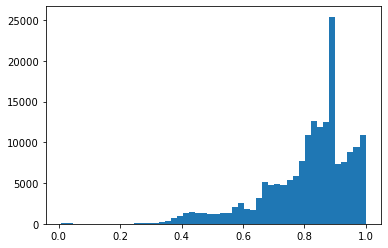

In [63]:
plt.hist(y_pred, bins=50)
plt.show()

In [67]:
mask = y_pred > 0.4
x_train, x_valid = train_test_split(train.loc[mask].drop(drop_features, axis=1), train_size=0.6, shuffle=True, random_state=47)
y_train, y_valid = train_test_split(train.loc[mask][TARGET_COLUMN], train_size=0.6, shuffle=True, random_state=47)
x_valid, x_test = train_test_split(x_valid, train_size=0.5, shuffle=True, random_state=47)
y_valid, y_test = train_test_split(y_valid, train_size=0.5, shuffle=True, random_state=47)
x_public = test.drop(drop_features, axis=1)
y_public = test[TARGET_COLUMN]
print("x_train = {} rows, {} cols".format(*x_train.shape))
print("x_valid = {} rows, {} cols".format(*x_valid.shape))
print("x_test = {} rows, {} cols".format(*x_test.shape))
print("x_public = {} rows, {} cols".format(*x_public.shape))

x_train = 106519 rows, 391 cols
x_valid = 35507 rows, 391 cols
x_test = 35507 rows, 391 cols
x_public = 100001 rows, 391 cols


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.69s/it]


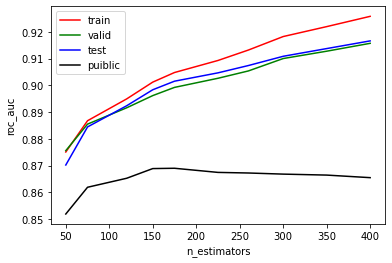

Wall time: 3min 47s


In [68]:
%%time
train_score = []
valid_score = []
test_score = []
public_score = []
n_estimators = [50, 75, 120, 150, 175, 225, 260, 300, 350, 400]
eval_set = [(x_valid, y_valid)]

for estimator in tqdm(n_estimators):
    cb_model = cb.CatBoostClassifier(cat_features=categorial_features, eval_metric='AUC', n_estimators=estimator,
                                     max_depth=5, early_stopping_rounds=10, learning_rate=0.1,
                                     silent=True, random_state=47
                                    )
    cb_model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, cb_model.predict_proba(x_train)[::, 1]))
    valid_score.append(roc_auc_score(y_valid, cb_model.predict_proba(x_valid)[::, 1]))
    test_score.append(roc_auc_score(y_test, cb_model.predict_proba(x_test)[::, 1]))
    public_score.append(roc_auc_score(y_public, cb_model.predict_proba(x_public)[::, 1]))

plt.plot(n_estimators, train_score, label='train', color='red')
plt.plot(n_estimators, valid_score, label='valid', color='green')
plt.plot(n_estimators, test_score, label='test', color='blue')
plt.plot(n_estimators, public_score, label='public', color='black')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

In [79]:
cb_model = cb.CatBoostClassifier(cat_features=categorial_features, eval_metric='AUC', n_estimators=160,
                                     max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                     silent=True, random_state=47
                                    )
cb_model.fit(x_train, y_train, eval_set=eval_set)

In [80]:
print(roc_auc_score(y_public, cb_model.predict_proba(x_public)[:, 1]))

0.8645321330995902


In [81]:
np.random.seed(1)
scores = create_bootstrap_metrics(y_test, cb_model.predict_proba(x_test)[:, 1], roc_auc_score)
calculate_confidence_interval(scores)

(0.8824898166494941, 0.9048094977119722)

Сильно лучше ситуация не стала

# Задание 5:
сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [84]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          X_test: pd.DataFrame,
                          y_test: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores, fold_test_scores = [], [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]
        y_test_pred = estimator.predict_proba(X_test)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        fold_test_scores.append(metric(y_test, y_test_pred))
        oof_predictions[valid_idx] = y_valid_pred
        left_bound, right_bound = calculate_confidence_interval(create_bootstrap_metrics(y_test, 
                                                                                         y_test_pred, metric))
        
        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}, " 
            f"test-score = {round(fold_test_scores[fold_number], 4)}, " 
            f"confidence_interval = {round(left_bound, 4), round(right_bound, 4)}"
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"CV-results test: {round(np.mean(fold_test_scores), 4)} +/- {round(np.std(fold_test_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, fold_test_scores, oof_predictions

In [90]:
cb_model = cb.CatBoostClassifier(cat_features=categorial_features, eval_metric='AUC', n_estimators=200,
                                     max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                     silent=True, random_state=47
                                    )

In [91]:
cv_strategy = KFold(n_splits=5, random_state=47)

estimators, oof_score, fold_train_scores, fold_valid_scores, fold_test_scores, oof_predictions = \
make_cross_validation(
    train.drop(drop_features, axis=1), train[TARGET_COLUMN], 
    test.drop(drop_features, axis=1), test[TARGET_COLUMN],
    cb_model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.903, valid-score = 0.8756, test-score = 0.8643, confidence_interval = (0.8575, 0.8714)
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.9036, valid-score = 0.8965, test-score = 0.8628, confidence_interval = (0.8562, 0.8694)
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.9024, valid-score = 0.8943, test-score = 0.8636, confidence_interval = (0.857, 0.8704)
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.8998, valid-score = 0.8856, test-score = 0.8604, confidence_interval = (0.8536, 0.8668)
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.9028, valid-score = 0.8751, test-score = 0.862, confidence_interval = (0.8552, 0.8687)
CV-results train: 0.9023 +/- 0.001
CV-results valid: 0.8854 +/- 0.009
CV-results test: 0.8626 +/- 0.001
OOF-score = 0.8829
